# Regularized Logistic Regression
This is the second part of exercise 3, and the objective here is to come up with logit model that can predict whether a given microchip will pass or fail quality standards based on the results of two tests done on the chip.

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures

## Reading and Previewing the Data

In [2]:
data = pd.read_csv('Data\\ex03b.csv', header=None,
                   names=['test1', 'test2', 'accepted'])

In [3]:
data.shape

(118, 3)

In [4]:
data.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [5]:
groups = data.groupby('accepted')
groups.describe()

test1      test2
accepted                            
0        count  60.000000  60.000000
         mean    0.090816   0.180203
         std     0.582990   0.586239
         min    -0.830070  -0.769740
         25%    -0.471490  -0.367690
         50%     0.094469   0.092838
         75%     0.619997   0.712353
         max     1.070900   1.108900
1        count  58.000000  58.000000
         mean    0.017499   0.186100
         std     0.389523   0.445792
         min    -0.628460  -0.601610
         25%    -0.278510  -0.190422
         50%    -0.078341   0.242690
         75%     0.322000   0.569808
         max     0.736750   0.962720

## Visualizing the Data

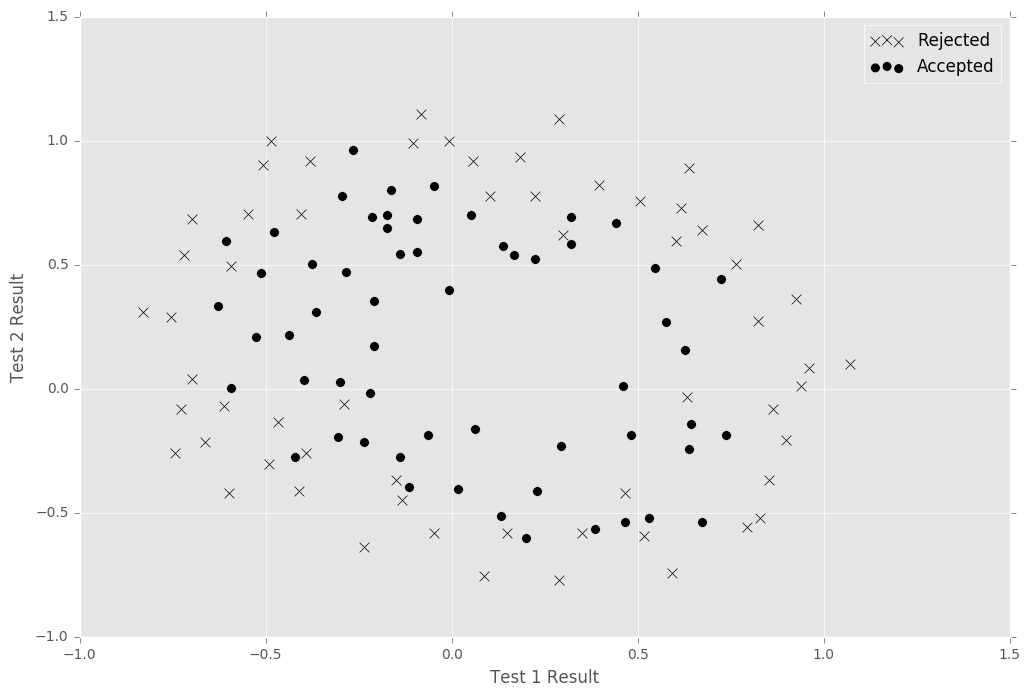

In [6]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))

markers = ['x', 'o']
labels = ['Rejected', 'Accepted']

for name, group in groups:
    ax.scatter(group['test1'], group['test2'], s=50, c='k',
               marker=markers[name], label=labels[name])

ax.legend()
ax.set_xlabel('Test 1 Result')
ax.set_ylabel('Test 2 Result')
plt.show()

The figure indicates that a straightline decision boundary does not fit the data very well. One possible way to model the above relationship might be to include polynomial terms of the two variables. However, this can lead to the problem of "overfitting" so we have to apply regularization to avoid overfitting as much as we possibly can.

## Creating Polynomial Features
The exercise text recommends trying out polynomial features of up to the sixth degree using the two test results variables. The scikit-learn package has a handy implementation of the feature mapping function used in Prof. Ng's exercise. Here's how I applied the scikit-learn approach.

In [7]:
test_res = data.loc[0:, ['test1', 'test2']]

ndeg = 6
poly = PolynomialFeatures(degree=ndeg)

X = poly.fit_transform(test_res)

type(X)

numpy.ndarray

In [8]:
X.shape

(118, 28)

## Vectorizing the Other Variables

In [9]:
# the target variable
m, _ = data.shape
y = np.reshape(data.accepted.values, (m, 1))
y.shape

(118, 1)

In [10]:
# Defining and initializing the parameter vector theta
_, nparams = X.shape
theta = np.zeros(nparams)
theta.shape

(28,)

## Regularized Cost and Gradient Functions
Now, we define the sigmoid, cost, and gradient functions (with modificiations to the latter two to take regularization into account).

### Sigmoid Function
Simply copies from exercise 03b notebook:

In [11]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

### Cost Function

In [12]:
def cost(theta, X, y, regrate=1):
    theta = np.matrix(theta).T
    X = np.matrix(X)
    y = np.matrix(y)
    m, _ = y.shape
    z = X * theta
    cost_i = np.log(sigmoid(z)) + np.diag(y.A1 - 1) * z
    reg_term = (regrate * np.sum(np.power(theta[1:], 2))) / (2 * m)
    return ((-np.sum(cost_i)) / m) + reg_term

In [13]:
# trying out the cost function
cost(theta=theta, X=X, y=y)

0.6931471805599454

### Gradient Function

In [14]:
def gradient(theta, X, y, regrate=1):
    theta = np.matrix(theta).T
    X = np.matrix(X)
    y = np.matrix(y)
    m = y.shape[0]
    n = theta.shape[0]
    
    z = X * theta
    
    reg_vec = np.matrix(np.zeros(shape=(n, 1)))
    reg_vec[1:] = regrate
    reg_diag = np.eye(n) * reg_vec
    
    grad = (X.T * (sigmoid(z) - y)) + reg_diag
    return (grad.A1) / m

## Optimization

We use the exact same optimization thingfrom exercise 03.

In [15]:
res = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
res[0]

array([ 1.09992038,  0.9222891 ,  1.36730465, -1.65845007, -0.72412214,
       -1.63842239,  0.28419047, -0.76324911, -0.74300378,  0.07516549,
       -1.1770608 , -0.50700822, -1.39347331, -0.62466693, -0.97428932,
       -0.06804798, -0.8409312 , -0.85729562, -1.04614785, -0.8098019 ,
        0.05302666, -0.76387659, -0.64987463, -1.2069548 , -0.80877819,
       -1.18871854, -0.65204552, -0.3326596 ])

Those are the values of the estimated parameters of our logistic regression model and, of course, they really don't make sense as they appear above. Let's use the estimates to find the minimum overall cost.

In [16]:
cost(theta=res[0], X=X, y=y)

0.58140186708619612

## Prediction and Accuracy
Again, we re-use some lines of code from ex 03.

In [17]:
def predict(theta_hat, X):
    theta_hat = np.matrix(theta_hat).T
    X = np.matrix(X)
    z = X * theta_hat
    y_hat = z > 0
    return y_hat.astype(int)

In [18]:
y_hat = predict(theta_hat=res[0], X=X)

In [19]:
# Checking accuracy of prediction
y_hat = np.reshape(y_hat, (len(y_hat), 1))       # turn y_hat into mx1
correct = y == y_hat
accuracy = (np.sum(correct.astype(float)) / m) * 100
accuracy

81.355932203389841